In [919]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [920]:
# Load the dataset
job_df = pd.read_csv('upwork.csv')

In [921]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


> ### Task 1:  Analyze the correlation between job title keywords and offered salaries

In [922]:
# Convert 'published_date' to datetime format
job_df['published_date'] = pd.to_datetime(job_df['published_date'], errors='coerce')

In [923]:
# Fill missing values
job_df['hourly_low'] = job_df['hourly_low'].fillna(job_df['hourly_low'].mean())
job_df['hourly_high'] = job_df['hourly_high'].fillna(job_df['hourly_high'].mean())
job_df['budget'] = job_df['budget'].fillna(job_df['budget'].mean())
job_df['title'] = job_df['title'].fillna('')
job_df['country'] = job_df['country'].fillna(method='ffill')
job_df['published_date'] = pd.to_datetime(job_df['published_date'], errors='coerce')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\4142178305.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  job_df['country'] = job_df['country'].fillna(method='ffill')


In [924]:
# Normalize numerical features
scaler = MinMaxScaler()
job_df[['hourly_low', 'hourly_high', 'budget']] = scaler.fit_transform(job_df[['hourly_low', 'hourly_high', 'budget']])

In [925]:
job_df.to_csv('job_df.csv',index=False)

In [926]:
# Calculate the average salary if it is an hourly job
job_df['avg_hourly'] = (job_df['hourly_low'] + job_df['hourly_high']) / 2
job_df['salary'] = job_df.apply(lambda x: x['avg_hourly'] if x['is_hourly'] else x['budget'], axis=1)

In [927]:
job_df2 = job_df.copy()

> #### Keyword Extraction

In [928]:
# Extract keywords using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(job_df['title'])


In [929]:
# Get feature names (keywords)
keywords = tfidf_vectorizer.get_feature_names_out()

In [930]:
# Create a DataFrame with the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

In [931]:
# Concatenate the TF-IDF DataFrame with the original job DataFrame
job_df = pd.concat([job_df, tfidf_df], axis=1)

In [932]:
# Calculate average salary for each keyword
keyword_salary = {}
for keyword in keywords:
    keyword_jobs = job_df[job_df[keyword] > 0]
    if not keyword_jobs.empty:
        keyword_salary[keyword] = keyword_jobs['salary'].mean()

In [933]:
# Convert the dictionary to a DataFrame for easier analysis
keyword_salary_df = pd.DataFrame.from_dict(keyword_salary, orient='index', columns=['average_salary'])
keyword_salary_df = keyword_salary_df.sort_values(by='average_salary', ascending=False)
keyword_salary_df

,average_salary
engineer,0.025590
sales,0.023343
work,0.021826
ads,0.021574
software,0.021239
...,...
entry,0.010098
english,0.010047
native,0.009745
channel,0.009261


In [934]:
correlation_results = {}
for keyword in keywords:
    correlation = job_df[keyword].corr(job_df['salary'])
    correlation_results[keyword] = correlation

# Convert the results to a DataFrame for easier analysis    
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['correlation'])


# Sort the DataFrame by correlation values
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

In [935]:
correlation_df

,correlation
sales,0.048090
engineer,0.039634
expert,0.037328
ads,0.032984
work,0.025541
...,...
channel,-0.029469
logo,-0.029825
english,-0.030046
youtube,-0.036727


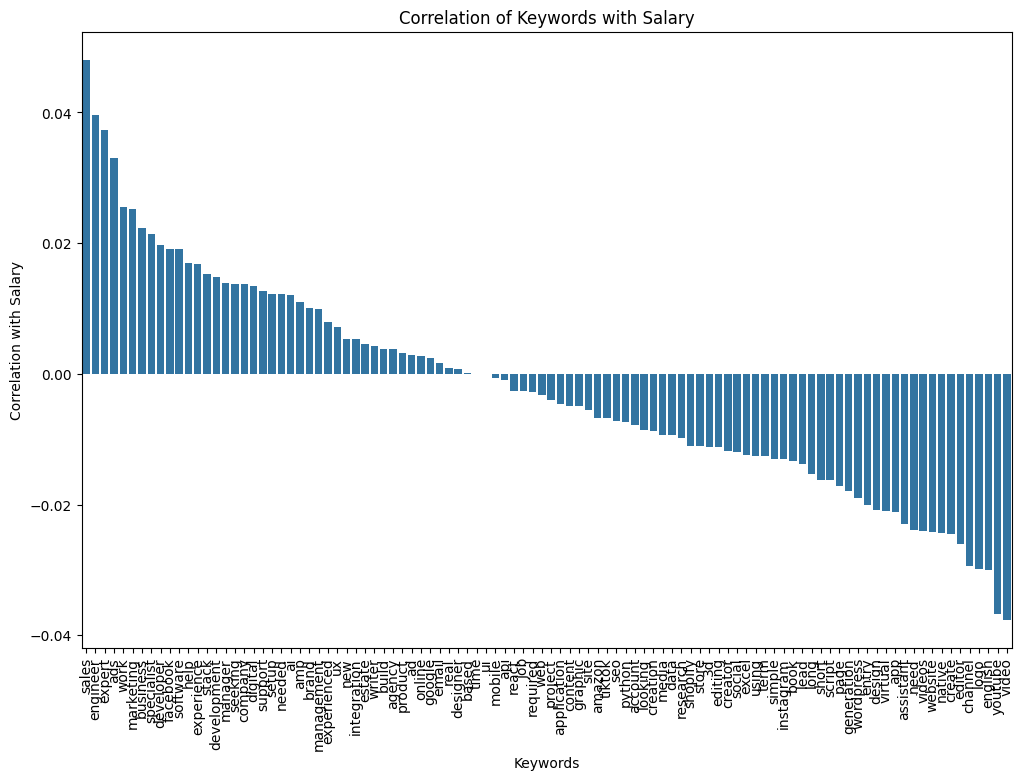

In [936]:
#  Plot the correlation of keywords with salary
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df.index, y=correlation_df['correlation'])
plt.xticks(rotation=90)
plt.title('Correlation of Keywords with Salary')
plt.xlabel('Keywords')
plt.ylabel('Correlation with Salary')
plt.show()

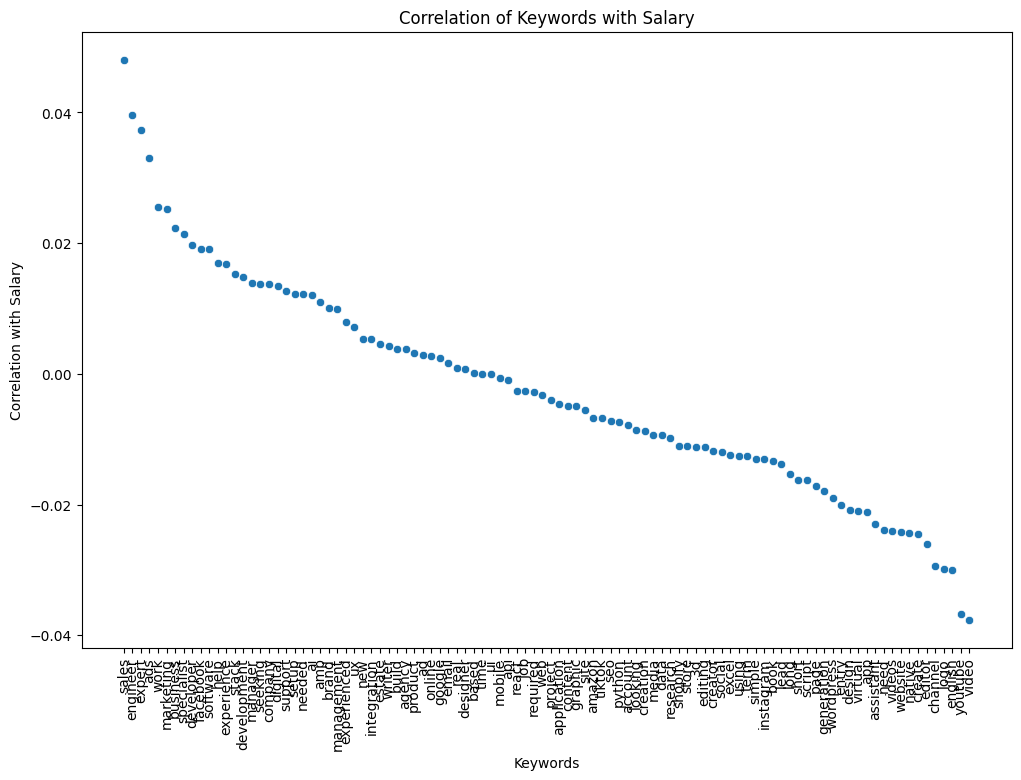

In [937]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=correlation_df.index, y=correlation_df['correlation'])
plt.xticks(rotation=90)
plt.title('Correlation of Keywords with Salary')
plt.xlabel('Keywords')
plt.ylabel('Correlation with Salary')
plt.show()

In [938]:
keyword_salary_df['keyword_length'] = keyword_salary_df.index.str.len()

In [939]:
keyword_salary_df.head()

,average_salary,keyword_length
engineer,0.025590,8
sales,0.023343,5
work,0.021826,4
ads,0.021574,3
software,0.021239,8


In [940]:
correlation = keyword_salary_df['keyword_length'].corr(keyword_salary_df['average_salary'])
print("Correlation between keyword length and average salary:", correlation)

Correlation between keyword length and average salary: 0.08871890302585486


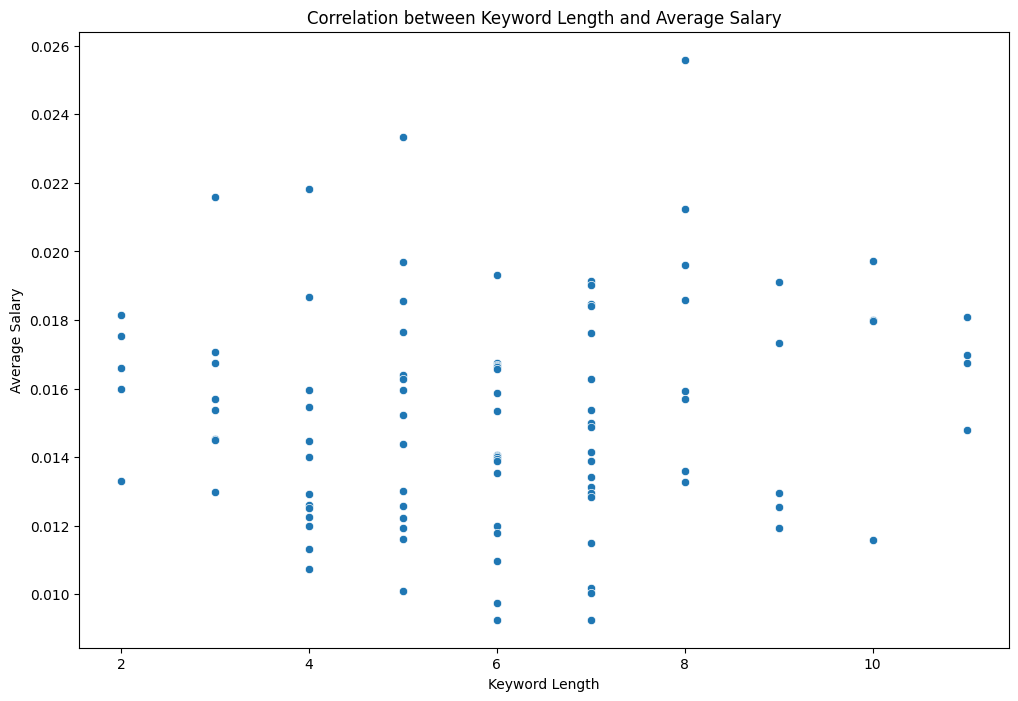

In [941]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='keyword_length', y='average_salary', data=keyword_salary_df)
plt.title('Correlation between Keyword Length and Average Salary')
plt.xlabel('Keyword Length')
plt.ylabel('Average Salary')
plt.show()

> ### Task 2: Identify emerging job categories based on posting frequency
    - Objective: To identify new and emerging job categories by analyzing the frequency and trend of job postings.
    - Deliverables: A list of emerging job categories with growth analysis over time


In [942]:
job_df['published_date'] = pd.to_datetime(job_df['published_date'], errors='coerce')
job_df['month_year'] = job_df['published_date'].dt.to_period('M')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\1474258378.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  job_df['month_year'] = job_df['published_date'].dt.to_period('M')


In [943]:
category_counts = job_df.groupby(['month_year']).size()

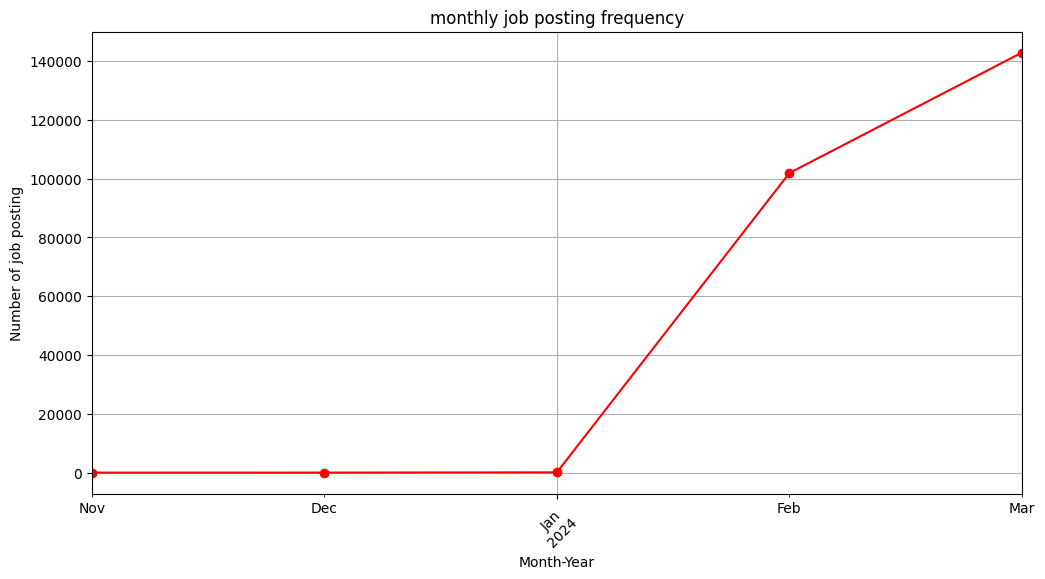

In [944]:
plt.figure(figsize=(12,6))
category_counts.plot(kind='line',marker='o',color = 'r')
plt.title('monthly job posting frequency')
plt.xlabel('Month-Year')
plt.ylabel('Number of job posting')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Task 3: Predict high-demand job roles by analyzing job posting patterns over time

>	Objective: To forecast high-demand job roles based on historical job posting data.

>	Deliverables: A predictive model with accuracy metrics, and a visual representation of demand trends over time.


In [945]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,mean_squared_error
from datetime import datetime
from sklearn.cluster import KMeans


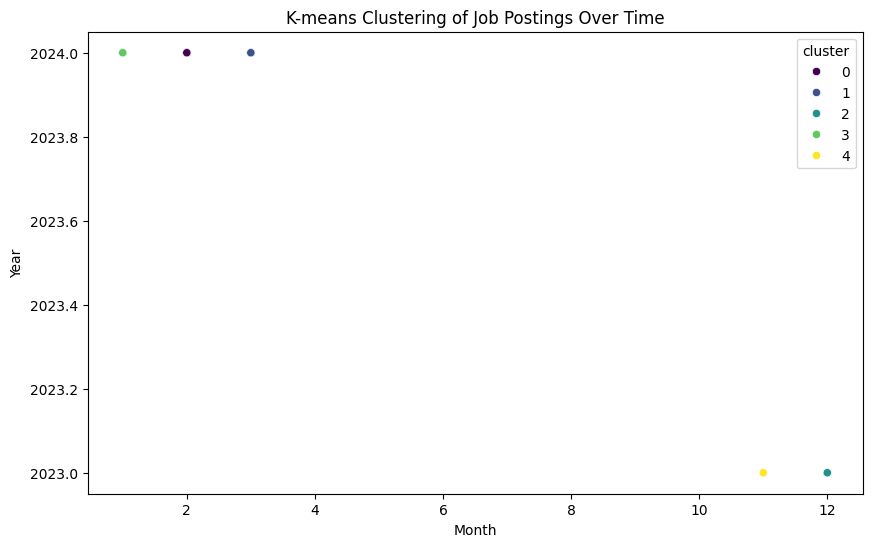

In [946]:
job_df['published_date'] = pd.to_datetime(job_df['published_date'])

# Extract temporal features
job_df['month'] = job_df['published_date'].dt.month
job_df['year'] = job_df['published_date'].dt.year

# Optional: Create lag features for historical trends
# job_df['lag_1'] = job_df['column'].shift(1)

# Select relevant features for clustering
X = job_df[['month', 'year']]  # Add lag features if applicable

# Initialize and fit K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels back to the dataset
job_df['cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='month', y='year', hue='cluster', data=job_df, palette='viridis', legend='full')
plt.title('K-means Clustering of Job Postings Over Time')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


In [947]:
# Extract relevant features
job_df['month'] = job_df['published_date'].dt.month
job_df['year'] = job_df['published_date'].dt.year
job_df['is_hourly'] = job_df['is_hourly'].astype(int)  


In [948]:
# Example: Creating lag features for hourly_low column
lag_features = pd.DataFrame()
for i in range(1, 13):
    lag_features[f'lag_{i}'] = job_df['hourly_low'].shift(i)


In [949]:
# Concatenate lag features with original dataframe
job_df = pd.concat([job_df, lag_features], axis=1)
job_df.shape

(244828, 126)

In [950]:
# Drop rows with NaN values introduced by shifting
job_df.dropna(inplace=True)

In [951]:
job_df.shape

(244815, 126)

In [952]:
# Define target variable 'high_demand' based on a criterion (example)
job_df['high_demand'] = (job_df['hourly_low'] > 50).astype(int)  #  High demand if hourly_low > 50


In [953]:
# Split data into train and test sets
X = job_df[['month', 'year', 'is_hourly'] + [f'lag_{i}' for i in range(1, 13)]]
y = job_df['high_demand']

In [954]:
X

,month,year,is_hourly,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
12,2,2024,1,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035,0.014412,0.014412
13,2,2024,1,0.014412,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035,0.014412
14,2,2024,0,0.037186,0.014412,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035
15,2,2024,1,0.014412,0.037186,0.014412,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412
16,2,2024,0,0.027136,0.014412,0.037186,0.014412,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244823,3,2024,1,0.014412,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412,0.014412,0.027136
244824,3,2024,0,0.017085,0.014412,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412,0.014412
244825,3,2024,1,0.014412,0.017085,0.014412,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412
244826,3,2024,0,0.002010,0.014412,0.017085,0.014412,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412


 Visualization of Demand Trends Over Time

In [955]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [956]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

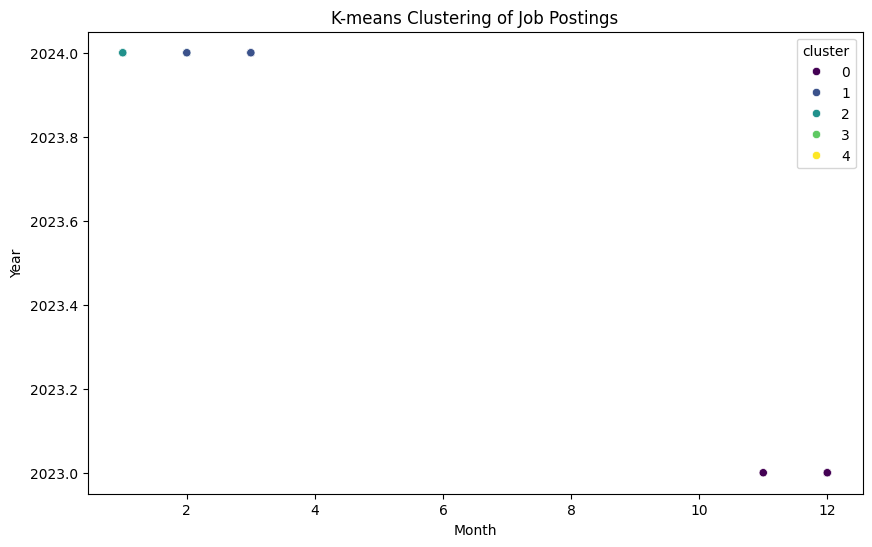

In [957]:
job_df['cluster'] = clusters

# Visualize clusters (example with two features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='month', y='year', hue='cluster', data=job_df, palette='viridis', legend='full')
plt.title('K-means Clustering of Job Postings')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [958]:
# Steps to Analyze Cluster Characteristics


In [959]:
#using clustering

In [960]:
df = job_df[['title']]

In [961]:
df

,title
12,Affiliate Marketing
13,URGENT: Fix Emails Not Working on Discourse In...
14,US Located So-Me Manager
15,Web3 Full-stack Developer
16,Shopify Store speed Optimization
...,...
244823,Need Facebook advertising experts to launch pr...
244824,Digital/Telemarketing/Sales/OutSide Sales
244825,WordPress Template Edits
244826,ELEMENTOR PRO For quick fix (Wordpress)


In [962]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Example DataFrame creation

# Text preprocessing: lowercase and remove non-word characters
df.loc[:, 'title_clean'] = df['title'].str.lower().replace('[^\w\s]', '', regex=True)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['title_clean'])

# Dimensionality reduction with TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X)

# Clustering with K-Means
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_svd)

# Assign cluster labels back to the DataFrame
df['cluster'] = clusters

# Display the DataFrame with cluster labels
print(df)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\4004107526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'title_clean'] = df['title'].str.lower().replace('[^\w\s]', '', regex=True)


                                                    title  \
12                                    Affiliate Marketing   
13      URGENT: Fix Emails Not Working on Discourse In...   
14                               US Located So-Me Manager   
15                              Web3 Full-stack Developer   
16                       Shopify Store speed Optimization   
...                                                   ...   
244823  Need Facebook advertising experts to launch pr...   
244824          Digital/Telemarketing/Sales/OutSide Sales   
244825                           WordPress Template Edits   
244826            ELEMENTOR PRO For quick fix (Wordpress)   
244827              Creating a UGC Ad for Our Mobile Game   

                                              title_clean  cluster  
12                                    affiliate marketing        2  
13      urgent fix emails not working on discourse ins...        2  
14                                us located some manager   

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\4004107526.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


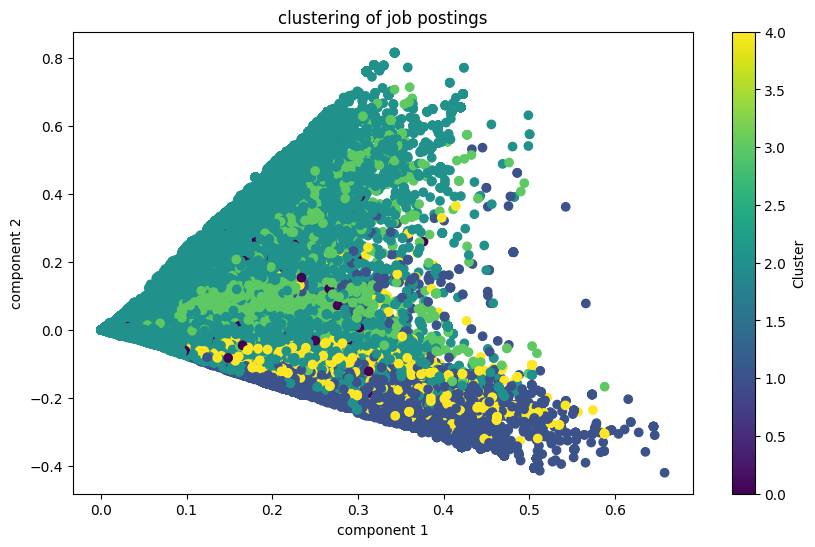

In [963]:
plt.figure(figsize=(10,6))
plt.scatter(X_svd[:,0],X_svd[:,1],c = clusters,cmap='viridis')
plt.title('clustering of job postings')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='Cluster')
plt.show()

In [964]:
# print top terms for each clusters

terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(k):
    print(f"cluster {i}")
    for j in centroids[i,:10]:
        print(f" -{terms[j]} ")
    print()

cluster 0
 -article 
 -artist 
 -animator 
 -art 
 -asap 
 -10 
 -architect 
 -amazon 
 -2d 
 -articles 

cluster 1
 -10 
 -3d 
 -500 
 -account 
 -2d 
 -accounting 
 -ai 
 -amp 
 -ads 
 -angular 

cluster 2
 -10 
 -100 
 -30 
 -accountant 
 -ad 
 -accounts 
 -advertising 
 -administrative 
 -affiliate 
 -500 

cluster 3
 -30 
 -3d 
 -10 
 -100 
 -agencies 
 -accountant 
 -agency 
 -app 
 -angular 
 -analysis 

cluster 4
 -10 
 -add 
 -admin 
 -amazon 
 -accounts 
 -ads 
 -animation 
 -animator 
 -analysis 
 -apps 



Task 4: Compare average hourly rates across different countries

>	Objective: To compare and analyze the average hourly rates offered across different geographical locations.

>	Deliverables: An interactive map or chart showing hourly rates by country.


In [965]:
job_df

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,avg_hourly,salary,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,high_demand
12,Affiliate Marketing,https://www.upwork.com/jobs/Affiliate-Marketin...,2024-02-17 09:04:27+00:00,1,0.014412,0.039127,0.000906,Singapore,0.026769,0.026769,...,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035,0.014412,0.014412,0
13,URGENT: Fix Emails Not Working on Discourse In...,https://www.upwork.com/jobs/URGENT-Fix-Emails-...,2024-02-17 09:04:14+00:00,1,0.037186,0.072289,0.000906,United Kingdom,0.054738,0.054738,...,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035,0.014412,0
14,US Located So-Me Manager,https://www.upwork.com/jobs/Located-Manager_%7...,2024-02-17 09:04:05+00:00,0,0.014412,0.039127,0.000295,Denmark,0.026769,0.000295,...,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0.007035,0
15,Web3 Full-stack Developer,https://www.upwork.com/jobs/Web3-Full-stack-De...,2024-02-17 09:04:02+00:00,1,0.027136,0.047189,0.000906,Malaysia,0.037162,0.037162,...,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0.014412,0
16,Shopify Store speed Optimization,https://www.upwork.com/jobs/Shopify-Store-spee...,2024-02-17 09:03:55+00:00,0,0.014412,0.039127,0.000000,United States,0.026769,0.000000,...,0.014412,0.014412,0.014412,0.014412,0.014412,0.004020,0.014412,0.014412,0.014412,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244823,Need Facebook advertising experts to launch pr...,https://www.upwork.com/jobs/Need-Facebook-adve...,2024-03-24 13:28:38+00:00,1,0.017085,0.097390,0.000906,Zambia,0.057237,0.057237,...,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412,0.014412,0.027136,0
244824,Digital/Telemarketing/Sales/OutSide Sales,https://www.upwork.com/jobs/Digital-Telemarket...,2024-03-24 13:40:52+00:00,0,0.014412,0.039127,0.000095,Sri Lanka,0.026769,0.000095,...,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412,0.014412,0
244825,WordPress Template Edits,https://www.upwork.com/jobs/WordPress-Template...,2024-03-24 13:37:50+00:00,1,0.002010,0.027108,0.000906,United States,0.014559,0.014559,...,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0.014412,0
244826,ELEMENTOR PRO For quick fix (Wordpress),https://www.upwork.com/jobs/ELEMENTOR-PRO-For-...,2024-03-24 13:52:15+00:00,0,0.014412,0.039127,0.000010,France,0.026769,0.000010,...,0.014412,0.014412,0.022111,0.014412,0.032161,0.014412,0.014412,0.014412,0.014412,0


In [966]:
job_df2

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,avg_hourly,salary
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,0.014412,0.039127,0.000495,NaN,0.026769,0.000495
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,0.014412,0.039127,0.001095,United States,0.026769,0.001095
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,0.007035,0.027108,0.000906,United States,0.017072,0.017072
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,0.014412,0.039127,0.000906,United States,0.026769,0.026769
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,0.014412,0.039127,0.000645,India,0.026769,0.000645
...,...,...,...,...,...,...,...,...,...,...
244823,Need Facebook advertising experts to launch pr...,https://www.upwork.com/jobs/Need-Facebook-adve...,2024-03-24 13:28:38+00:00,True,0.017085,0.097390,0.000906,Zambia,0.057237,0.057237
244824,Digital/Telemarketing/Sales/OutSide Sales,https://www.upwork.com/jobs/Digital-Telemarket...,2024-03-24 13:40:52+00:00,False,0.014412,0.039127,0.000095,Sri Lanka,0.026769,0.000095
244825,WordPress Template Edits,https://www.upwork.com/jobs/WordPress-Template...,2024-03-24 13:37:50+00:00,True,0.002010,0.027108,0.000906,United States,0.014559,0.014559
244826,ELEMENTOR PRO For quick fix (Wordpress),https://www.upwork.com/jobs/ELEMENTOR-PRO-For-...,2024-03-24 13:52:15+00:00,False,0.014412,0.039127,0.000010,France,0.026769,0.000010


In [967]:
job_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   title           244828 non-null  object             
 1   link            244827 non-null  object             
 2   published_date  244828 non-null  datetime64[ns, UTC]
 3   is_hourly       244828 non-null  bool               
 4   hourly_low      244828 non-null  float64            
 5   hourly_high     244828 non-null  float64            
 6   budget          244828 non-null  float64            
 7   country         244827 non-null  object             
 8   avg_hourly      244828 non-null  float64            
 9   salary          244828 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(5), object(3)
memory usage: 17.0+ MB


In [968]:
job_df2.dropna(subset=['hourly_low','hourly_high'],inplace=True)

job_df2['hourly_low'] = pd.to_numeric(job_df2['hourly_low'])
job_df2['hourly_high'] = pd.to_numeric(job_df2['hourly_high'])

In [969]:
job_df2['average_hourly_rate']= (job_df2['hourly_low']+job_df2['hourly_high'])/2

In [970]:
country_hourly_rate = job_df2.groupby('country')['average_hourly_rate'].mean().reset_index()

In [971]:
country_hourly_rate.sort_values(by='average_hourly_rate', ascending=False,inplace=True)

In [972]:
print('Top countries by average hourly rate')
print(country_hourly_rate.head(10))

Top countries by average hourly rate
                      country  average_hourly_rate
106                      Laos             0.154250
61                    Eritrea             0.062091
115                    Malawi             0.044038
195  Turks and Caicos Islands             0.043814
135      Netherlands Antilles             0.037344
109             Liechtenstein             0.034530
116                  Malaysia             0.033144
188                  Thailand             0.031682
68              French Guiana             0.031137
29     British Virgin Islands             0.030590


Task 6: Track changes in job market dynamics over months

>	Objective: To monitor and track the changes in job market dynamics.

>	Deliverables: A dashboard that updates monthly with new trends in the job market.


In [973]:
job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\2983327758.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')


In [974]:
monthly_job_counts = job_df2.groupby('month_year').size()

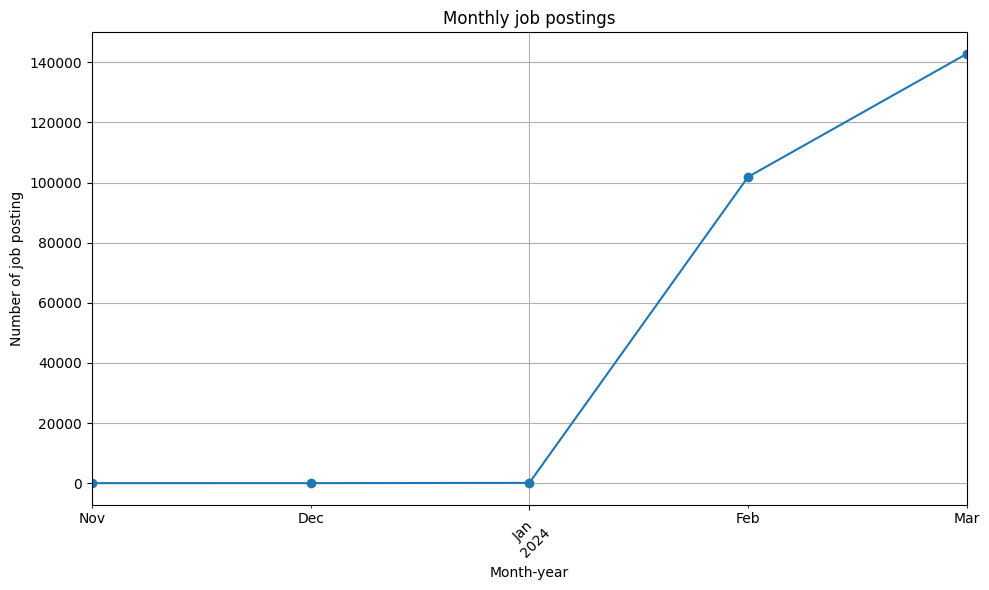

In [975]:
plt.figure(figsize=(10,6))
monthly_job_counts.plot(marker='o',linestyle='-')
plt.title('Monthly job postings')
plt.xlabel('Month-year')
plt.ylabel('Number of job posting')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Task 7: Investigate trends in the remote work landscape
>	Objective: To analyze trends and shifts towards remote work.

>	Deliverables: A comprehensive report on remote work trends with data-backed forecasts.


In [976]:
job_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244828 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244828 non-null  datetime64[ns, UTC]
 3   is_hourly            244828 non-null  bool               
 4   hourly_low           244828 non-null  float64            
 5   hourly_high          244828 non-null  float64            
 6   budget               244828 non-null  float64            
 7   country              244827 non-null  object             
 8   avg_hourly           244828 non-null  float64            
 9   salary               244828 non-null  float64            
 10  average_hourly_rate  244828 non-null  float64            
 11  month_year           244828 non-null  period[M]          
dtypes:

In [977]:
print(job_df2.isnull().sum())

title                  0
link                   1
published_date         0
is_hourly              0
hourly_low             0
hourly_high            0
budget                 0
country                1
avg_hourly             0
salary                 0
average_hourly_rate    0
month_year             0
dtype: int64


In [978]:
job_df2['country'] = job_df2['country'].fillna(method='ffill')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\1631715402.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  job_df2['country'] = job_df2['country'].fillna(method='ffill')


In [979]:
job_df2['published_date'] = pd.to_datetime(job_df2['published_date'])
job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\968756545.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')


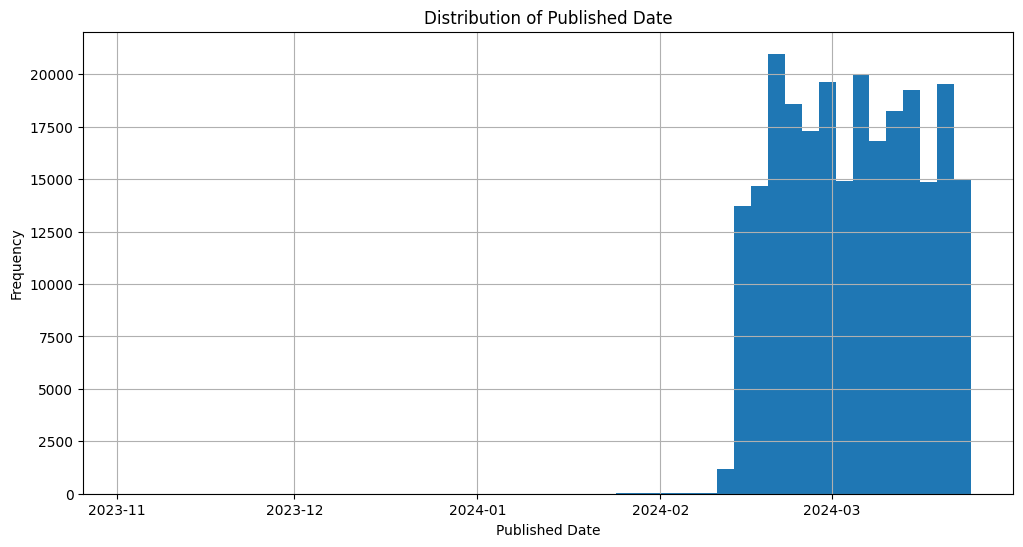

In [980]:
plt.figure(figsize=(12, 6))
job_df2['published_date'].hist(bins=50)
plt.title('Distribution of Published Date')
plt.xlabel('Published Date')
plt.ylabel('Frequency')
plt.show()

In [981]:
# Trends in remote work over time
remote_work_trend = job_df2.groupby('month_year')['is_hourly'].mean()

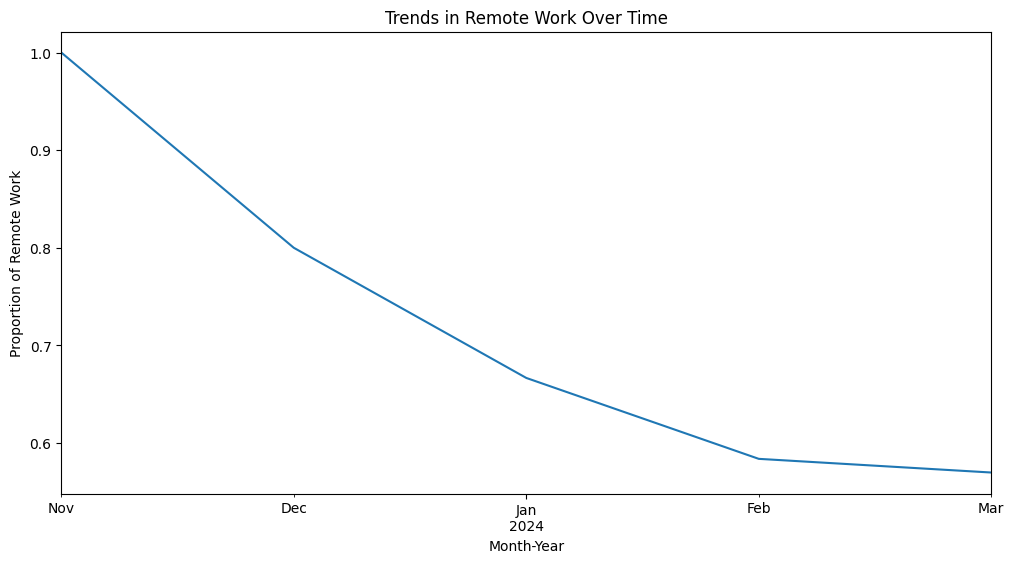

In [982]:
plt.figure(figsize=(12, 6))
remote_work_trend.plot()
plt.title('Trends in Remote Work Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Proportion of Remote Work')
plt.show()

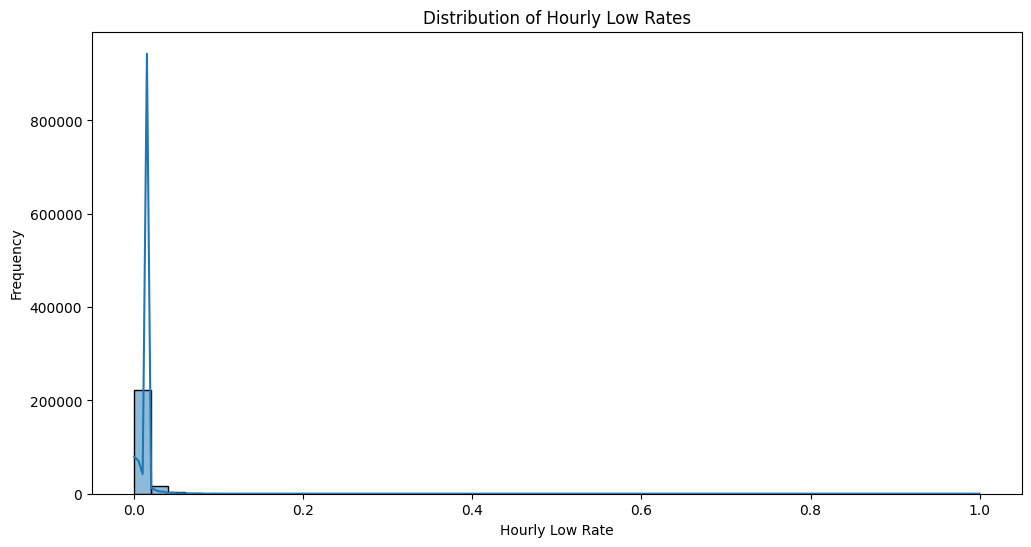

In [983]:
# Distribution of hourly rates and salary
plt.figure(figsize=(12, 6))
sns.histplot(job_df2['hourly_low'], bins=50, kde=True)
plt.title('Distribution of Hourly Low Rates')
plt.xlabel('Hourly Low Rate')
plt.ylabel('Frequency')
plt.show()

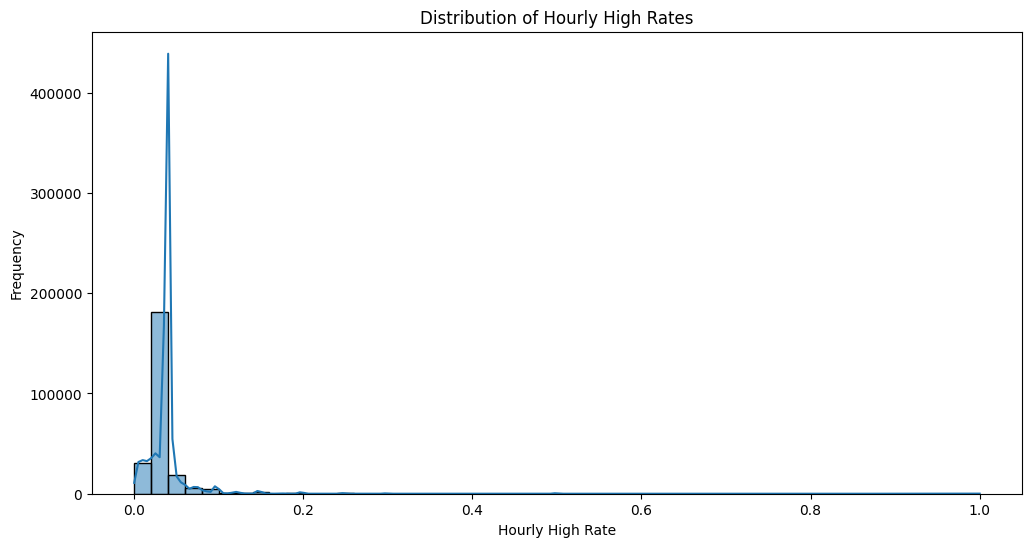

In [984]:
plt.figure(figsize=(12, 6))
sns.histplot(job_df2['hourly_high'], bins=50, kde=True)
plt.title('Distribution of Hourly High Rates')
plt.xlabel('Hourly High Rate')
plt.ylabel('Frequency')
plt.show()

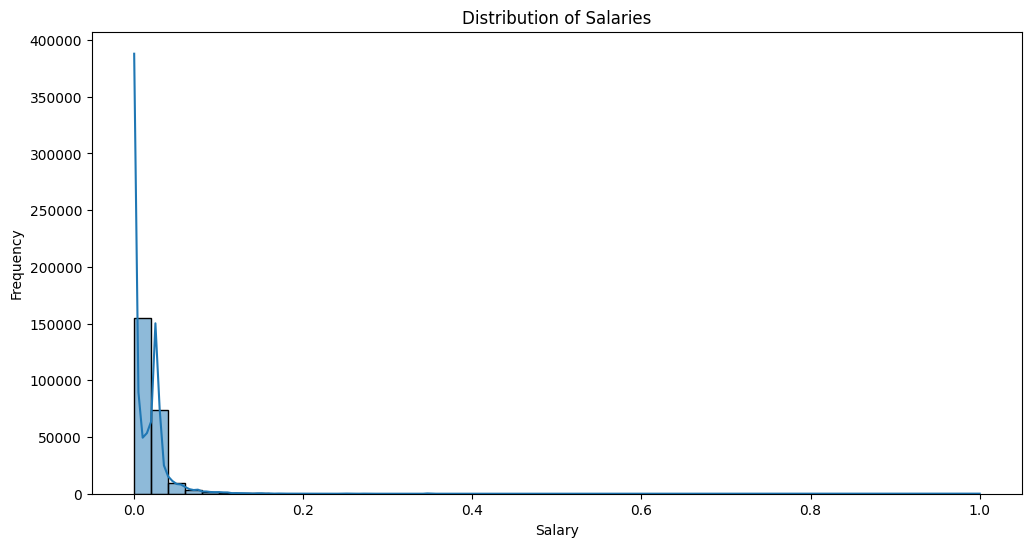

In [985]:
plt.figure(figsize=(12, 6))
sns.histplot(job_df2['salary'], bins=50, kde=True)
plt.title('Distribution of Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

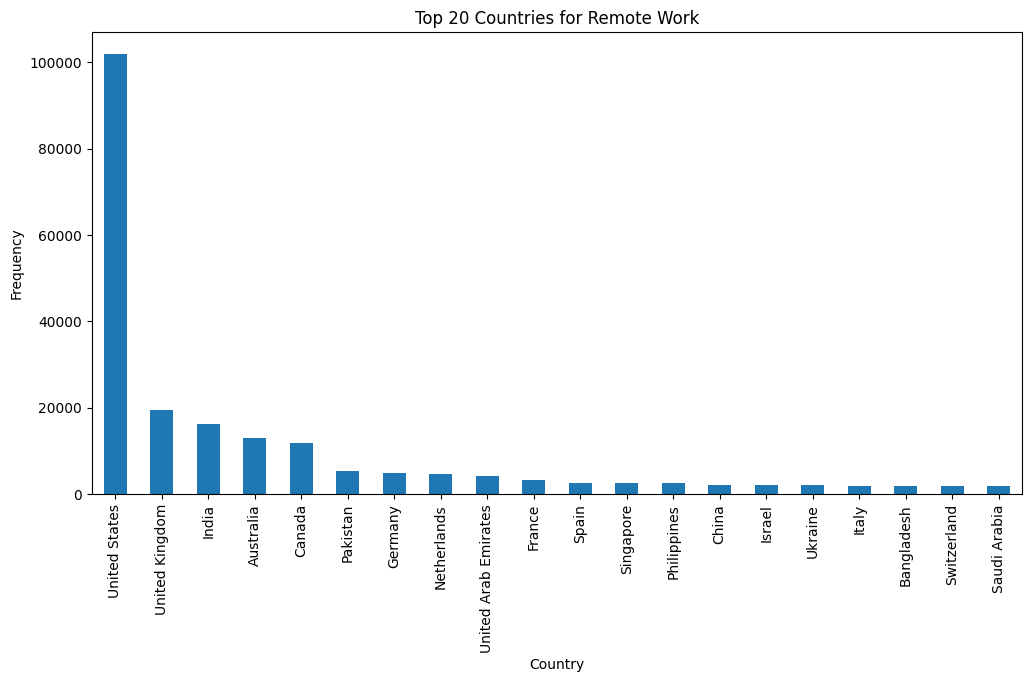

In [986]:
# Geographical trends
country_trend = job_df2['country'].value_counts()
plt.figure(figsize=(12, 6))
country_trend.head(20).plot(kind='bar')
plt.title('Top 20 Countries for Remote Work')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

Task 8: Predict future job market trends
>	Objective: To use the analyzed data to predict future trends in the job market.

>	Deliverables: A predictive analytics report with potential future scenarios.


In [987]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [988]:
# Convert 'date' to datetime format
job_df2['published_date'] = pd.to_datetime(job_df2['published_date'])

In [989]:
monthly_job_postings = job_df2.groupby('month_year').size()

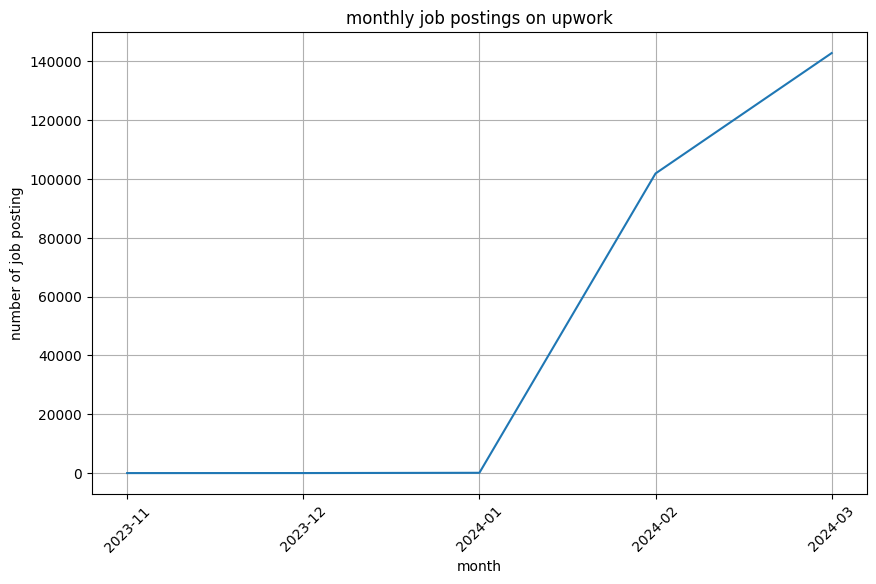

In [990]:
plt.figure(figsize=(10,6))
plt.plot(monthly_job_postings.index.astype(str),monthly_job_postings.values)
plt.title("monthly job postings on upwork")
plt.xlabel("month")
plt.ylabel("number of job posting")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [991]:
# Train_test split:
train_size = int(len(monthly_job_postings)*0.8)
train,test=monthly_job_postings[:train_size],monthly_job_postings[train_size:]

In [992]:
# ARIMA MODEL

model = ARIMA(train,order=(5,1,0))
model_fit = model.fit()

d:\study material\recomendation algorithm\job recomedation sysytem project\jobenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [993]:
forecast = model_fit.forecast(steps=len(test))

In [994]:
rmse = np.sqrt(mean_squared_error(test,forecast))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 60874.408


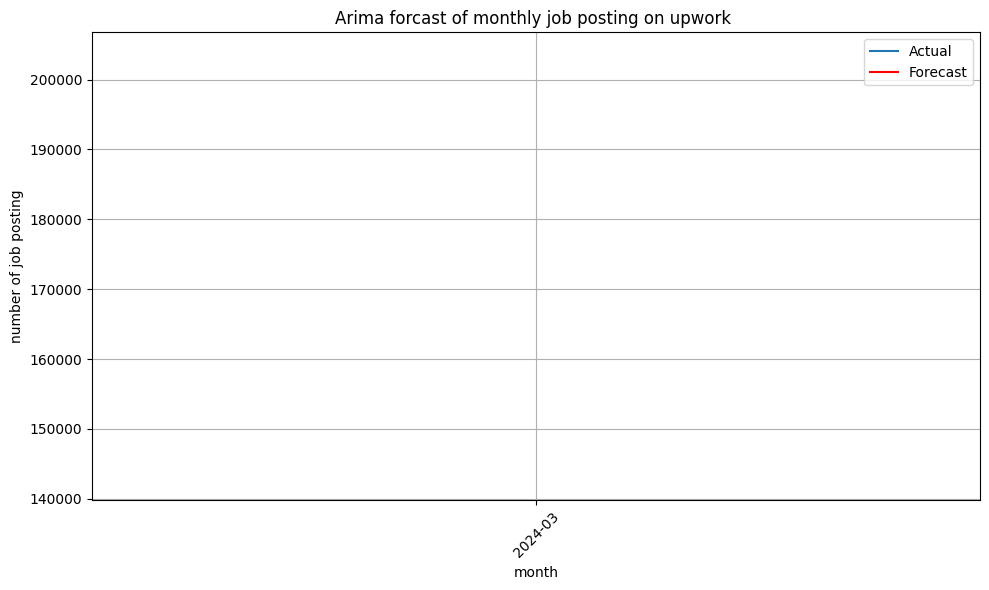

In [995]:
plt.figure(figsize=(10,6))
plt.plot(test.index.astype(str),test.values,label='Actual')
plt.plot(test.index.astype(str),forecast,color='red',label='Forecast')
plt.title('Arima forcast of monthly job posting on upwork ')
plt.xlabel('month')
plt.ylabel('number of job posting')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



### using LSTM

In [996]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10548\2609591546.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')


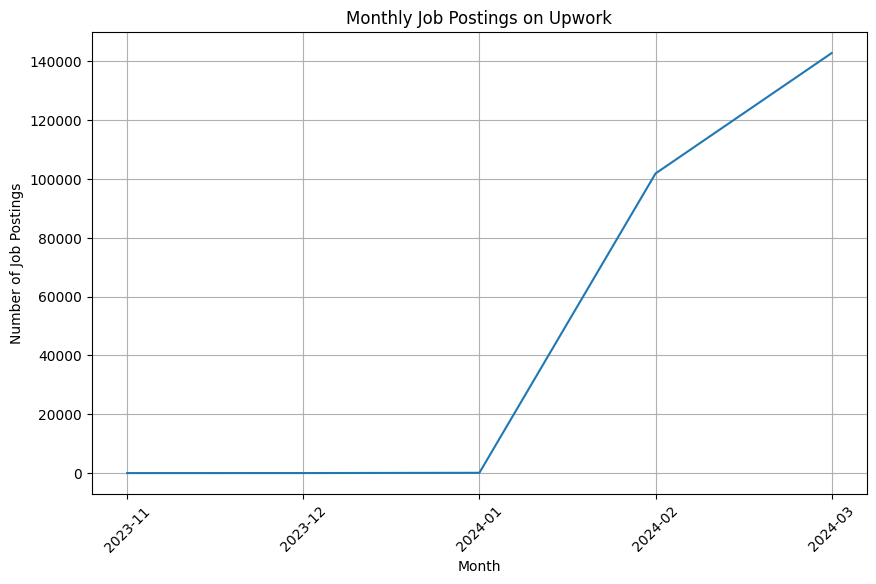

In [997]:
# Prepare data for LSTM
job_df2['published_date'] = pd.to_datetime(job_df2['published_date'])
job_df2['month_year'] = job_df2['published_date'].dt.to_period('M')



# Aggregate by 'month_year' to get monthly job postings (assuming 'title' or another column as count)
monthly_job_postings = job_df2.groupby('month_year').size()
# Plotting the data (optional)
plt.figure(figsize=(10, 6))
plt.plot(monthly_job_postings.index.astype(str), monthly_job_postings.values)
plt.title("Monthly Job Postings on Upwork")
plt.xlabel("Month")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

data = monthly_job_postings.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [998]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [999]:
# Create sequences for LSTM
seq_length = 3  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)


In [1000]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [1001]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



d:\study material\recomendation algorithm\job recomedation sysytem project\jobenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1002]:
# Train LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5088
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5013
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4937
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4859
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4779
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4697
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4613
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4527
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4439
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4349
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4256
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4161
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4064
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3964
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3862
Epoch 16/100
1/1 ━━━━

In [1003]:
# Predict using LSTM model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [1004]:
# Inverse transform predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


In [1013]:
print(y_train_inv,train_predictions)

[[101887.]] [[103344.055]]


In [1014]:
print(y_test_inv,test_predictions)

[[142834.]] [[119262.96]]


In [1005]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predictions))
print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % test_rmse)

Train RMSE: 1457.055
Test RMSE: 23571.039


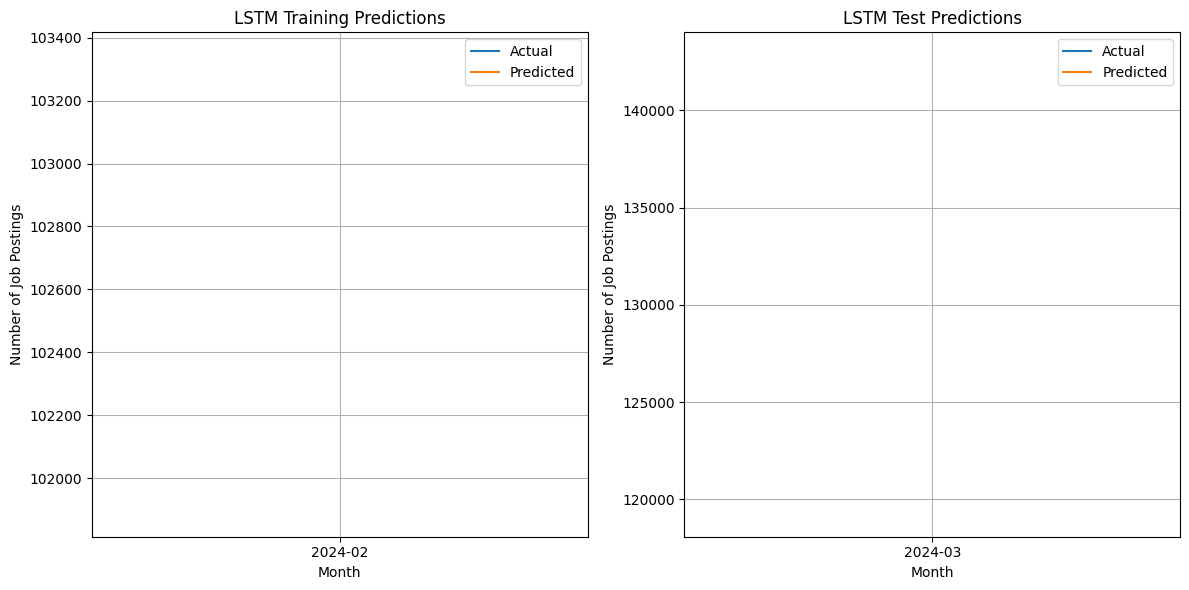

In [1012]:
# Plotting predictions
plt.figure(figsize=(12, 6))

# Plot training predictions
# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(monthly_job_postings.index[seq_length:train_size+seq_length].astype(str), y_train_inv, label='Actual')
plt.plot(monthly_job_postings.index[seq_length:train_size+seq_length].astype(str), train_predictions, label='Predicted')
plt.title('LSTM Training Predictions')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.legend()
plt.grid(True)

# Plot test predictions
plt.subplot(1, 2, 2)
plt.plot(monthly_job_postings.index[train_size+seq_length:].astype(str), y_test_inv, label='Actual')
plt.plot(monthly_job_postings.index[train_size+seq_length:].astype(str), test_predictions, label='Predicted')
plt.title('LSTM Test Predictions')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()